### [Tutorial 1](https://www.tensors.net/p-tutorial-1) from tensors.net: Tensor Contractions

We'll learn the basics of manipulating tensors and contracting TN efficiently, including:

* Initialization of tensors
* Diamgrammatic notation for tensors and TN
* Manipulation tensors via 'permute' and 'reshape' functions
* Binary tensor contractions and computational costs
* Use of 'ncon' routine to contract TN

In [1]:
import numpy as np

In [3]:
# In Python, tensors are multidimensional (real or complex) arrays:
A = np.random.rand(2,3,4) # Random rank 3, dims: 2x3x4
print(A)

[[[0.90962708 0.72760315 0.20338668 0.29309864]
  [0.65924345 0.34166245 0.88935753 0.82431396]
  [0.00179676 0.86935287 0.37809208 0.01198909]]

 [[0.53138278 0.42469535 0.41744175 0.11251908]
  [0.81120895 0.62099027 0.52455088 0.31874153]
  [0.76887779 0.16764894 0.53868505 0.84676683]]]


##### Binary tensor contractions

Given $A_{ijkl}$ and $B_{ijkl}$, we want to evaluate tensor $C_{ijkl} = \sum_{mn} A_{imjn} B_{mkln}$.

##### Method:

1. Permute the A and B tensors such that the indices to be contracted become the trailing and leading indices respectively (with consistent order between both tensors)

2. Reshape tensors into matrices (between indices to be contracted vs the remaining indices)

3. Do the matrix multiplication

4. Reshape C back into a tensor, perform final permutation if desired index ordering is different from current ordering

##### In our case:

Want to contract the 2nd index of A w/ 1st index of B and last index of A w/ last index of B. Therefore, I reorder the (0,1,2,3) indices of A $\to (0,2,1,3)$ so that the indices to be contracted are trailing, and for B: $(0,1,2,3) \to (0,3,1,2)$ the indices are leading.

When reshaping A and B as matrices (i.e. rank-2 tensors) they must be dimension (dimension indices to be contracted) x (the rest)

In [10]:
import time

#Choose some number for dimension
d = 100

t0 = time.time()
# Initialize tensors A and B (rank 4)
A = np.random.rand(d,d,d,d)
B = np.random.rand(d,d,d,d)

# Reorder A and B
Ap = A.transpose(0,2,1,3)
Bp = B.transpose(0,3,1,2)

# Reshape A and B. In this case the two dims (of contracted and the rest) are equal
App = Ap.reshape(d**2, d**2)
Bpp = Bp.reshape(d**2, d**2)

# Perform matrix multiplication
Cpp = App @ Bpp

# Reshape C back to rank-4
C = Cpp.reshape(d,d,d,d)

tf = time.time()

print('d:'+str( d), ', time(s):'+str( round(tf-t0, 4)))

d:100 , time(s):41.9643


##### Some time comparisons for different d

d = 10, t = 0.0014s

d = 20, t = 0.0161s

d = 50, t = 0.6864s

d = 100, t = 41.9643s

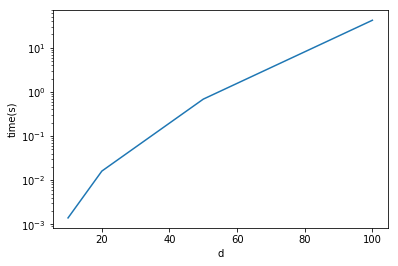

In [13]:
import matplotlib.pyplot as plt

d_test = [10, 20, 50, 100]
t_test = [0.0014, 0.0161, 0.6864, 41.9643]

plt.semilogy(d_test, t_test)
plt.xlabel('d')
plt.ylabel('time(s)')
plt.show()

#### Contraction costs

The cost of multiplying a $d_1 \times d_2$ matrix A with a $d_2 \times d_3$ matrix B is:
$$ \text{cost}(A \cdot B) = d_1 \cdot d_2 \cdot d_3. $$
Given the equivalence with matrix multiplication, this is also the cost of a binary tensor contraction (we're thinking of step 3 in the method of tensor contraction, right after reshaping A and B).

Another way of computing the cost of contracting A and B is to take the product of the total dimensions, denoted $|\text{dim}(A)|$ and $|\text{dim}(B)|$, divided by the total dimension of the contracted indices, denoted $|\text{dim}(A \cap B)|$:

$$\text{cost}(A \cdot B) = \frac{|\text{dim}(A)| |\text{dim}(B)|}{|\text{dim}(A \cap B)|}$$

**Example:** Assume A is rank-3 and B is rank-4, each index of which is d-dimensional.

$$ |\text{dim}(A)| = d^3, \quad |\text{dim}(B)| = d^4 $$

We contract 2 indices, so 

$$|\text{dim}(A \cap B)| = d^2.$$

Therefore,

$$\text{cost}(A \cdot B) = \frac{d^3 \cdot d^4}{d^2} = d^5.$$

Broadly speaking, there are two approaches to contract a TN (more than 2 tensors):

1. In a single step as a direct summation over all internal indices of the TN

2. As a sequence of N-1 binary contractions


In [16]:
# Example of a TN evaluation made of 3 (rank-2) tensors
d = 10

# Initialize tensors
A = np.random.rand(d,d)
B = np.random.rand(d,d)
C = np.random.rand(d,d)

# Evaluate TN via sequence of binary contractions
TN = (A @ B) @ C

Something important that we have to bear in mind is that the TN cost depends on the sequence of binary contractions used, i.e.  $\text{cost}((A @ B) @ C) \neq  \text{cost}((A @ C) @ B)$ in general. Thus, when contracting a TN we'll first have to determine the optimal sequence of the N-1 binary contractions.

Given a tensor network with only a few tensors it is often easy to find the optimal sequence ‘manually’ through inspection of the network. For more complicated networks with a large number of tensors it may be necessary to employ an automated search algorithm such as [this one](https://arxiv.org/abs/1304.6112).

Once the optimal contraction sequence has been determined, a TN can be evaluated by implementing each of the binary contractions in turn. However, using ‘reshape’ and ‘permute’ commands for each binary tensor contraction, although computationally effective, has two significant drawbacks: 

($i$) It results in lengthy code that is error prone and difficult to check and 

($ii$) It does not allow for the contraction sequence to be easily changed (as, in general, the entire code for the contraction would need to be rewritten to accommodate a different ordering).

##### TN contractor 'ncon':

In order to lessen the programming effort required to implement a TN contraction people invented the 'ncon' function. This function works by automatically performing a desired sequence of permutes, reshapes and matrix multiplications required to evaluate a TN.

The 'ncon' code and documentation can be found [here](https://arxiv.org/abs/1402.0939) (though it's MATLAB). Alternatively, in tensors.net there is an example code [page](https://www.tensors.net/code). The first step in using 'ncon' is to make a labelled diagram of the TN such that:

* Each internal index is labelled with a unique positive integer.

* External indices of the diagram (if any) are labelled with sequential negative numbers $[-1,-2,-3,\text{...}]$, which denote the desired index order on the final tensor (with -1 as the 1st index, -2 the 2nd, etc.).

Following this, the 'ncon' routine is called as follows,

$$\text{OutputTensor} = \text{ncon(TensorArray, IndexArray, ContOrder)},$$

with input arguments defined:

* **TensorArray:** 1D cell array containing the tensors comprising the TN.

* **IndexArray:** 1D cell array of vectors, whete the kth element is a vector of the integer labels from the diagram on the kth tensor from 'TensorArray'.

* **ContOrder:** a vector containing the positive integer labels from the diagram, used to specify order in which 'ncon' contracts the indices. This is an optional input that can be omitted if desired, in which case 'ncon' will contract in ascending order of index labels.

#### Example of TN contraction using 'ncon':

<center> <b>Network contraction:<b>

<img src="img/tutorial_1_ncon_example_1.png" alt="drawing" width="250"/>

<center> <b>Labelled network:<b>

<img src="img/tutorial_1_ncon_example_2.png" alt="drawing" width="200"/>

In [4]:
from ncon import ncon

# Initialize tensors of the TN
d = 10
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d,d)
C = np.random.rand(d,d,d)
D = np.random.rand(d,d)

# List of tensors in the TN
TensorArray = [A, B, C, D]

# Ordered indices labelled by clockwise starting at 6 o'clock
IndexArray = [[1, -2, 2], [-1, 1, 3, 4], [5, 3, 2], [4, 5]]

# TN evaluation using ncon
E = ncon(TensorArray, IndexArray)

#### Problem 1(b):

Given the following diagram:

<img src="img/tut_1_pb_1b.png" alt="drawing" width="550"/>

Initialize rank-3 tensors A, B, C (d = 20). Write code to evaluate the network contraction in two different ways:

* As a sequence of binary contractions implemented using 'permute' and 'reshape'

* Using the 'ncon' routine

Check that both approaches produce the same output tensor D, and compare their respective computation times

In [31]:
import time
from ncon import ncon

# Initialize tensors
d = 20
A = np.random.rand(d,d,d)
B = np.random.rand(d,d,d)
C = np.random.rand(d,d,d)

# First go for 'ncon' (easier)
t0 = time.time()

# List of tensors in the TN
TensorArray = [A, B, C]

# Ordered indices labelled by clockwise starting at 6 o'clock
IndexArray = [[1, -2, 2], [-1, 1, 3], [3, 2, -3]]

# TN evaluation using ncon
D_ncon = ncon(TensorArray, IndexArray)

tf = time.time()

print('ncon:'+str(round(tf-t0, 4))+'s')


# Now go for binary contractions. Had to think more
t0 = time.time()

AB = (A.transpose(1,2,0).reshape(d**2,d) @ B.transpose(1,2,0).reshape(d,d**2)).reshape(d,d,d,d)

D = (AB.transpose(3,0,2,1).reshape(d**2,d**2) @ C.reshape(d**2,d)).reshape(d,d,d)

tf = time.time()

print('binary:'+str(round(tf-t0, 4))+'s')

print(np.sum(D_ncon-D)/len(D))

ncon:0.0036s
binary:0.0016s
1.0572875908110292e-12
